# Squares classification 

Predict the image classes. 

In [1]:
import tensorflow as tf
print(tf.__version__)
tf_seed = 123
tf.random.set_seed(tf_seed)

import matplotlib.pyplot as plt
import cv2
import glob
import os

import wandb
wandb.init(project="Square Classification")


2.5.0


wandb: Currently logged in as: yueqiu (use `wandb login --relogin` to force relogin)


## Data Exploration and Visualization

### Dataset first impression

In [2]:
!tree -d ./squares

./squares
├── train
│   ├── a
│   ├── b
│   └── c
└── val
    ├── a
    ├── b
    └── c

8 directories


In [3]:
!ls -U ./squares/train/a/ | head -10

0.jpg
1.bmp
10.jpg
100.png
101.bmp
102.jpg
103.jpg
104.png
105.png
106.jpg


In [4]:
train_data_dir = "./squares/train/"
test_data_dir = "./squares/val/"

### Data extraction and processing

In [5]:
from collections import OrderedDict
class DataObj:
    """
    DataObj is an object that
    . Read and process data 
    . Provide statistics and visualization of the dataset. 
    """
    def __init__(self, data_dir, name, num_classes = 3):
        """
        Read and process data.

            Parameters:
                data_dir (string): Data directory path
                name (string): Could be "Train" or "Test". 
                num_classes(int): number of classes
        """
        
        self.data_dir = data_dir
        self.name = name
        self.num_classes = num_classes
        self.cls2files = {}
        
        class_dirs = glob.glob(os.path.join(data_dir, "*"))
        assert len(class_dirs) == num_classes
        for cd in class_dirs:
            all_files = [os.path.join(cd, f) for f in os.listdir(cd) if os.path.isfile(os.path.join(cd, f))]
            label = cd.split("/")[-1]
            self.cls2files[label] = list(filter(lambda x: 
                                               os.path.splitext(x)[1] == ".png" 
                                               or os.path.splitext(x)[1] == ".bmp" 
                                               or os.path.splitext(x)[1] == ".jpg"
                                              , all_files))
        self.cls2files = OrderedDict(sorted(self.cls2files.items()))
        assert len(self.cls2files) == num_classes
        assert len(self.cls2files["a"]) >= 200
        
    def DisplayStatistics(self,):
        """
        Display statistics of the dataset
        """
        
        fileSizes = []
        is_square = []
        has_three_channel = []
        img_sizes = []
        
        data = self.cls2files
        for key, val in data.items():
            print(f"class {key}: {len(val)} images")
            for path in val:
                img = cv2.imread(path)
                is_square.append(img.shape[0] == img.shape[1])
                has_three_channel.append(img.shape[2] == 3)
                img_sizes.append(img.shape[0])
        print(f"All images is square: {all(is_square)}")
        print(f"All images have three channels: {all(has_three_channel)}")
        plt.hist(img_sizes)
        plt.title("Image Size distribution")
        plt.show()
        
    def Visualize(self, n_samples_per_class = 3):
        """
        Visualize samples in the dataset in a x sample per class fashion.

            Parameters:
                n_samples_per_class (int): number of samples per class
        """

        plt.figure(figsize=(15, 15))
        data = self.cls2files
        for i, (label, files) in zip(range(self.num_classes), data.items()):
            for j in range(n_samples_per_class):
                ax = plt.subplot(n_samples_per_class, self.num_classes, 3 * j + i + 1)
                image = cv2.imread(files[j])
                plt.imshow(image)
                plt.title(f"{self.name}: class = {label}, size = {image.shape}" )
                plt.axis("off")
        plt.show()

### Training data statistics and visualization

class a: 500 images
class b: 500 images
class c: 500 images
All images is square: True
All images have three channels: True


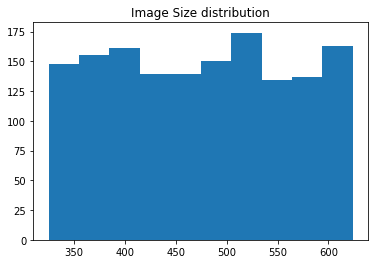

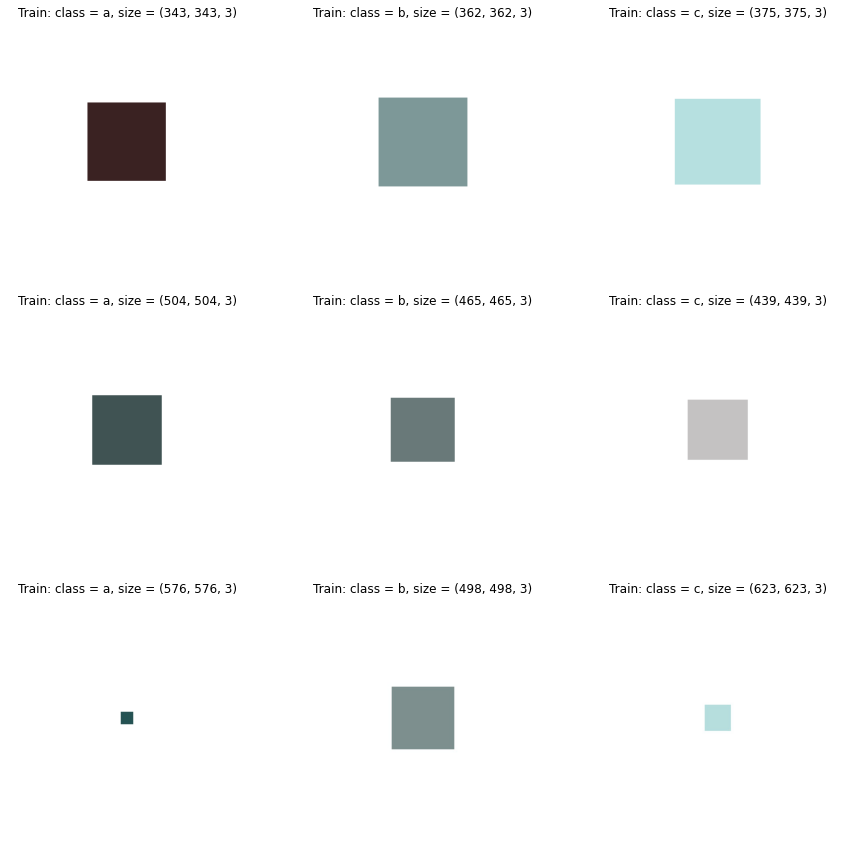

In [6]:
data = DataObj(train_data_dir, name = "Train")
data.DisplayStatistics()
data.Visualize()

### Insights from data statistics and data visualization

- Verifies the description of the dataset: each class has 500 samples
- All images are square images
- All images have three channels
- Images have difference sizes: Approximately a uniform distribution ranging from 325 - 624
- From observations from looking at more samples, the difference between classes lies in the color saturation of the square.

## Hyperparameters

In [7]:
cfg = wandb.config
cfg.img_height, cfg.img_width = 64, 64
cfg.batch_size = 32

## Data Preprocessing

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.3,
  subset="training",
  image_size=(cfg.img_height, cfg.img_width),
  seed = tf_seed,
  batch_size = cfg.batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.3,
  subset="validation",
  image_size=(cfg.img_height, cfg.img_width),
  seed = tf_seed,
  batch_size = cfg.batch_size,
)

class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)




Found 1500 files belonging to 3 classes.
Using 1050 files for training.
Found 1500 files belonging to 3 classes.
Using 450 files for validation.


train_ds


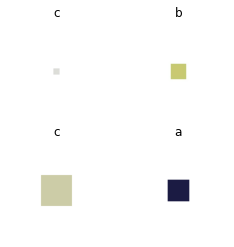

val_ds


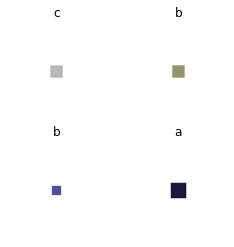

In [9]:
print("train_ds")
plt.figure(figsize=(4, 4))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()
print("val_ds")
plt.figure(figsize=(4, 4))
for images, labels in val_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## Model and Optimizer

In [10]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Training

In [12]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
33/33 [==============================] - 3s 62ms/step - loss: 1.0148 - accuracy: 0.4762 - val_loss: 0.7556 - val_accuracy: 0.6400
Epoch 2/10
33/33 [==============================] - 2s 54ms/step - loss: 0.5370 - accuracy: 0.7752 - val_loss: 0.4728 - val_accuracy: 0.8089
Epoch 3/10
33/33 [==============================] - 2s 56ms/step - loss: 0.3008 - accuracy: 0.8819 - val_loss: 0.4368 - val_accuracy: 0.8222
Epoch 4/10
33/33 [==============================] - 2s 53ms/step - loss: 0.2462 - accuracy: 0.9095 - val_loss: 0.1273 - val_accuracy: 0.9578
Epoch 5/10
33/33 [==============================] - 2s 56ms/step - loss: 0.1306 - accuracy: 0.9533 - val_loss: 0.1685 - val_accuracy: 0.9289
Epoch 6/10
33/33 [==============================] - 2s 53ms/step - loss: 0.1291 - accuracy: 0.9581 - val_loss: 0.0800 - val_accuracy: 0.9711
Epoch 7/10
33/33 [==============================] - 2s 53ms/step - loss: 0.0933 - accuracy: 0.9686 - val_loss: 0.0740 - val_accuracy: 0.9689
Epoch 8/10
33

In [13]:
# wandb.log({"train loss": 0.0958, "val accuracy": 0.9578 , 'val loss': 0.0939})


## Evaluation

In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  image_size=(cfg.img_height, cfg.img_width),
  batch_size = cfg.batch_size,
).map(lambda x, y: (normalization_layer(x), y))

Found 1500 files belonging to 3 classes.


In [15]:
results = model.evaluate(test_ds, batch_size=128)

47/47 [==============================] - 1s 15ms/step - loss: 0.0817 - accuracy: 0.9747


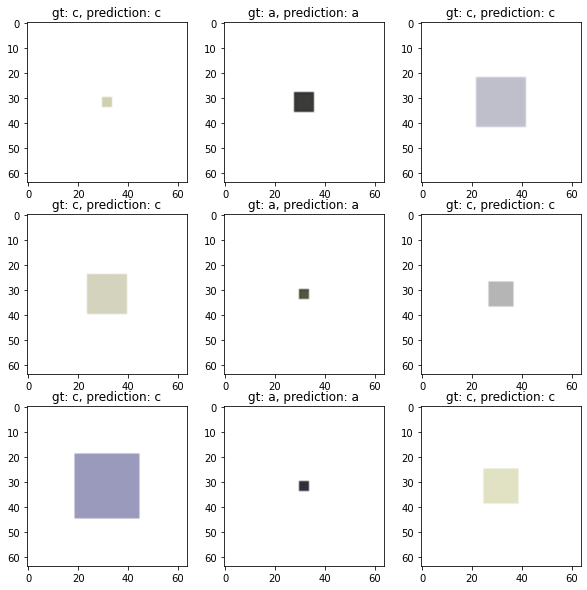

In [16]:
plt.figure(figsize = (10, 10))

for (img, gt) in test_ds.take(1):
    output = model.predict(img)
    confidence = tf.nn.softmax(output, axis = 1)
    preds = tf.argmax(confidence, axis = 1)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i])
        plt.title(f"gt: {class_names[gt[i]]}, prediction: {class_names[preds[i]]}")
        


### Error Analysis

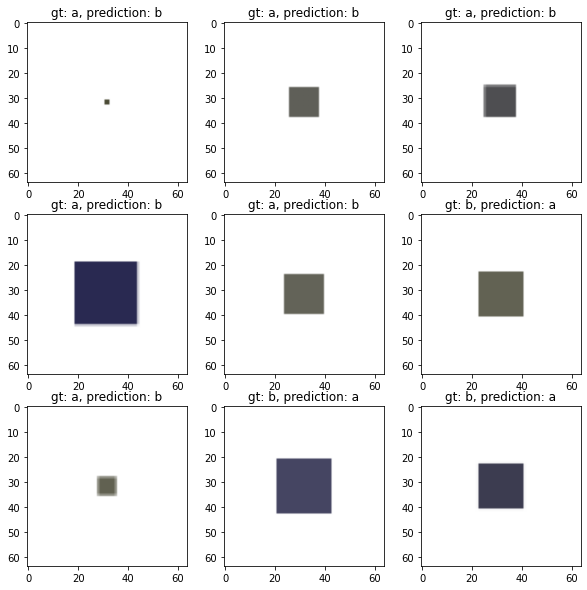

In [17]:
plt.figure(figsize = (10, 10))
plot_i = 1
it = iter(test_ds)
for (img, gt) in it:
    output = model.predict(img)
    confidence = tf.nn.softmax(output, axis = 1)
    preds = tf.argmax(confidence, axis = 1).numpy()
    gt = gt.numpy()
    correct = (preds == gt)
    for i, c in enumerate(correct):
        if not c:
            plt.subplot(3, 3, plot_i)
            plt.imshow(img[i])
            plt.title(f"gt: {class_names[gt[i]]}, prediction: {class_names[preds[i]]}")
            plot_i += 1
        if plot_i >= 10:
            break
    if plot_i >= 10:
        break
plt.show()
        


## Future Work

### Product

- Understand the requirements and the restraints better, e.g. inference latency, throughput, class importance, etc.

### Data Pipelines

- Decouple functionality of each step
- Unit tests, integration tests
- Data versioning


### Model and training

- Hyperparameters search with keras tuner
- Further Improve model accuracy through building better architecture.
- Reduce overfitting through regularization, dropout, etc.
- Reduce inference latency: experiments with more efficient network architectures like mobilenet and squeezenet.
- Custom training loop and evaluation metrics to gain more control. (e.g. Add recall and precision for each class to the metrics)
- Abalation study


## Reference

- https://www.tensorflow.org/tutorials/load_data/images
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/guide/keras/train_and_evaluate
- https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit